<a href="https://colab.research.google.com/github/AndreyKuratov/project_mldm_21/blob/main/MLDM_proj_4_simple_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Загрузка библиотек

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import soundfile as sf
import scipy.signal as signal
import os
from tqdm import tqdm

import os
import csv
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image

import librosa as lb 
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd

from skimage.transform import resize
from scipy import stats

from sklearn.preprocessing import MinMaxScaler
from skimage.transform import resize

# 1. Загрузка данных и меток

In [11]:
PATH_TO_DIR = '/content/drive/MyDrive/mldm21_project/'
PATH_TO_SAVE = '/content/drive/MyDrive/mldm21_project/'

data = np.load(PATH_TO_SAVE+'sr_48e3_nfft_2e11_hlop_2e9_pict_256x512_u8.npz',allow_pickle=True)
# 'imgs' 'labels'
labels = np.load(PATH_TO_SAVE+'labels_simple.npz')
# 'files_fp' 'labels_fp' 'files_tp' 'labels_tp'

labels_pd_fp = pd.read_csv('/content/drive/MyDrive/mldm21_project/train_fp.csv')
labels_pd_tp = pd.read_csv('/content/drive/MyDrive/mldm21_project/train_tp.csv')


пордок метод одиаков:

In [ ]:
np.sum(data['labels']!=labels['files_tp'])

0

Выбор меток которые соотвествуют TP с одним полезным сигналом, а так же преобразование выбор матриц-рисунков для этих меток

In [6]:
lbl,cnt_lbl = np.unique(labels_pd_tp['recording_id'].values,return_counts=True)

In [7]:
lbl_single = lbl[cnt_lbl==1]
length_1tp = len(lbl_single)
print(length_1tp)


1065


Извлечение данных

In [8]:
mask = np.isin(data['labels'], lbl_single)

In [9]:
data_to_nn = data['imgs'][mask].copy()
labels_to_nn = labels['labels_tp'][mask].copy()

In [12]:
print(data_to_nn.shape)
data_to_nn = np.swapaxes(data_to_nn,1,3)
print(data_to_nn.shape)

(1065, 256, 512, 3)
(1065, 3, 512, 256)


In [13]:
np.savez(PATH_TO_SAVE+'1signal_tp',data=data_to_nn,labels=labels_to_nn)

# 2. Исползование моделей

In [ ]:
import torchvision.models as models
import torch

import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms

#resnet18 = models.resnet18()
#alexnet = models.alexnet()
#vgg16 = models.vgg16()
#squeezenet = models.squeezenet1_0()
#densenet = models.densenet161()
#inception = models.inception_v3()
#googlenet = models.googlenet()
#shufflenet = models.shufflenet_v2_x1_0()
#mobilenet_v2 = models.mobilenet_v2()
#mobilenet_v3_large = models.mobilenet_v3_large()
#mobilenet_v3_small = models.mobilenet_v3_small()
#resnext50_32x4d = models.resnext50_32x4d()

In [ ]:
NUM_CLASSES = 3


num_classes = NUM_CLASSES


*   **resnet18,34,50**
*   **vgg16**
*   **alexnet**
*   **squeezenet**
*   **inception**
*  **mobilenet_v3_small**



In [ ]:
resnet18 = models.resnet18()
resnet18.fc = nn.Linear(512, num_classes)

resnet34 = models.resnet34()
resnet34.fc = nn.Linear(512, num_classes)

resnet50 = models.resnet50()
resnet50.fc = nn.Linear(2048, num_classes)


alexnet = models.alexnet()
alexnet.classifier[6] = nn.Linear(4096,num_classes)

vgg16 = models.vgg16()
vgg16.classifier[6] = nn.Linear(4096,num_classes)

squeezenet = models.squeezenet1_0()
squeezenet.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))

inception = models.inception_v3(aux_logits=False)  #'N x 3 x 299 x 299'
#inception.AuxLogits.fc = nn.Linear(768, num_classes)
inception.fc = nn.Linear(2048, num_classes)

mobilenet_v3_small = models.mobilenet_v3_small()
mobilenet_v3_small.classifier[0] = nn.Linear(in_features=576, out_features=4096, bias=True)
mobilenet_v3_small.classifier[3] = nn.Linear(4096,num_classes,bias=True)



/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:83: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


In [ ]:
model_stack = [resnet18,resnet34,resnet50, alexnet, vgg16, squeezenet,inception, mobilenet_v3_small ]
ModelNames = [str(imodel).split('(')[0] for imodel in model_stack]

Пример батча

In [ ]:
init = torch.Tensor(data_to_nn[0:4]).transpose(1,3)

for imodel in [resnet18,resnet34,resnet50,alexnet, vgg16, squeezenet,mobilenet_v3_small ]:
  ModelName = str(imodel).split('(')[0]
  print(ModelName) 
  print(imodel(init).size(),'\n')

ResNet
torch.Size([4, 3]) 

ResNet
torch.Size([4, 3]) 

ResNet
torch.Size([4, 3]) 

AlexNet
torch.Size([4, 3]) 

VGG
torch.Size([4, 3]) 

SqueezeNet
torch.Size([4, 3]) 

MobileNetV3
torch.Size([4, 3]) 



In [ ]:
from skimage.transform import resize
len_N = 4
init_incept = torch.Tensor(resize(data_to_nn[0:len_N],(len_N,299,299,3))).transpose(1,3)
init_incept.size()


torch.Size([4, 3, 299, 299])

In [ ]:
output = inception(init_incept)
torch.nn.functional.softmax(output, dim=0)


tensor([[0.1990, 0.3022, 0.3035],
        [0.3283, 0.3180, 0.2667],
        [0.2399, 0.1649, 0.2031],
        [0.2327, 0.2148, 0.2267]], grad_fn=<SoftmaxBackward0>)

# 3. Применение моделей

In [4]:
import torchvision.models as models
import torch

import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms

NUM_CLASSES = 24

def crtclass(mdTp,num_classes=24):
  if mdTp == 'Res18':
    modelF = models.resnet18()
    modelF.fc = nn.Linear(512, num_classes)
  elif mdTp == 'Res34':
    modelF = models.resnet34()
    modelF.fc = nn.Linear(512, num_classes)
  elif mdTp == 'Res50':
    modelF = models.resnet50()
    modelF.fc = nn.Linear(2048, num_classes)
  elif mdTp == 'Alex':
    modelF = models.alexnet()
    modelF.classifier[6] = nn.Linear(4096,num_classes)
  elif mdTp == 'VGG':
    modelF = models.vgg16()
    modelF.classifier[6] = nn.Linear(4096,num_classes)
  elif mdTp == 'Squeez':
    modelF = models.squeezenet1_0()
    modelF.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
  elif mdTp == 'Modile_v3':
    modelF = models.mobilenet_v3_small()
    modelF.classifier[0] = nn.Linear(in_features=576, out_features=4096, bias=True)
    modelF.classifier[3] = nn.Linear(4096,num_classes,bias=True)
  else:
    assert False, 'no model'
  return modelF

In [ ]:
model  = crtclass('Res18')

# 4. Создание dataset dataloader

Постоянные

In [108]:
TEST_SIZE = 0.1
BATCH_SIZE = 8
LR = 1e-1
MOMENTUM = 0.9

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCH_NUM = 100


print(DEVICE)

cuda


In [109]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import DataLoader

class simpleDataset(Dataset):
    def __init__(self, numpy_dataset,numpy_labels,transform=None, target_transform=None):
        self.dataset = numpy_dataset
        self.labels = numpy_labels
        self.length = len(numpy_labels)
        self.target_transform = target_transform
        self.transform = transform

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if self.transform != None:
          data = self.transform(self.dataset[idx])
        else:
          data = self.dataset[idx]
        if self.target_transform != None:
          target = self.target_transform(self.labels[idx])
        else:
          target = self.labels[idx]
        return data, target

деление данных на тест и трейн

In [110]:
PATH_TO_DIR = '/content/drive/MyDrive/mldm21_project/'
PATH_TO_SAVE = '/content/drive/MyDrive/mldm21_project/'

data_archive = np.load(PATH_TO_SAVE+'1signal_tp.npz')

img_data = data_archive['data']
img_labels = data_archive['labels']

In [111]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( img_data, img_labels, test_size=TEST_SIZE, random_state=42)

In [112]:
train_dataset = simpleDataset(X_train,y_train)
test_dataset = simpleDataset(X_test,y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [113]:
import torch.optim as optim


model = crtclass('Res34').to(DEVICE)
best_model = crtclass('Res34')

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)

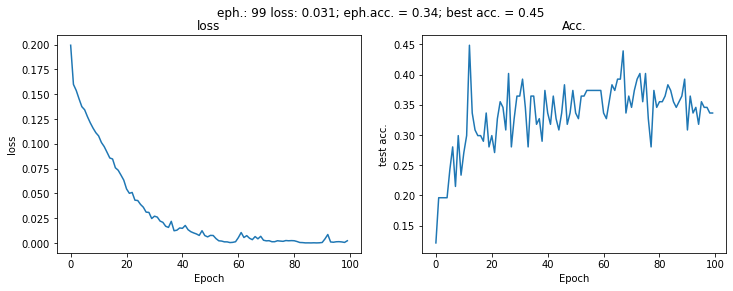

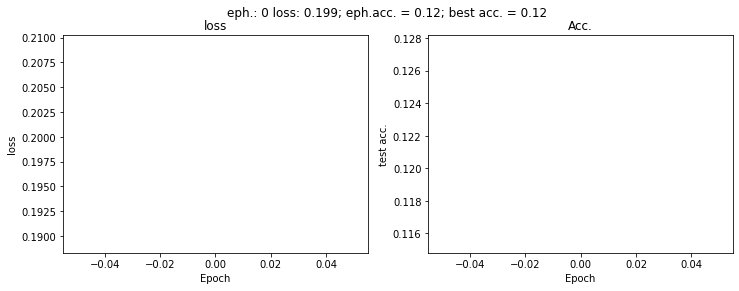

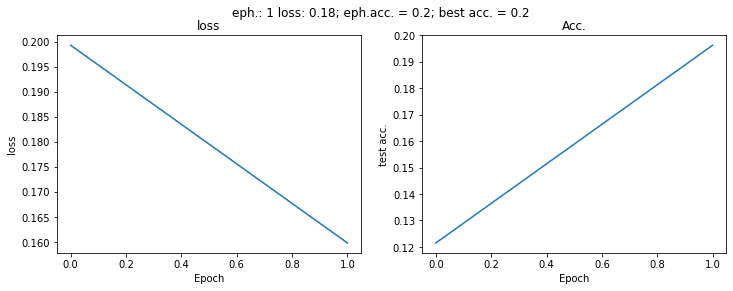

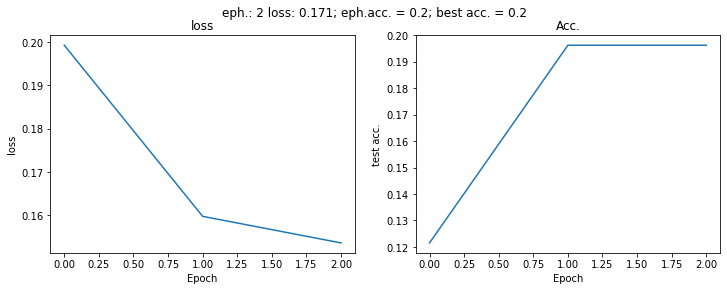

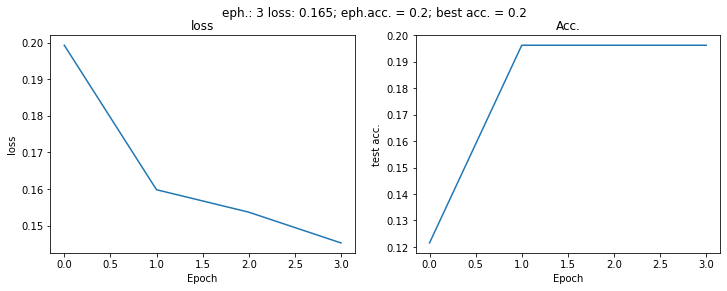

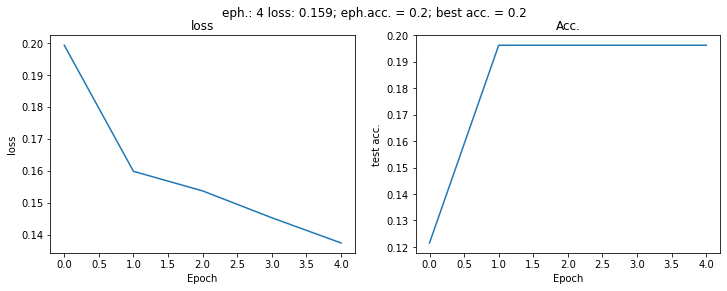

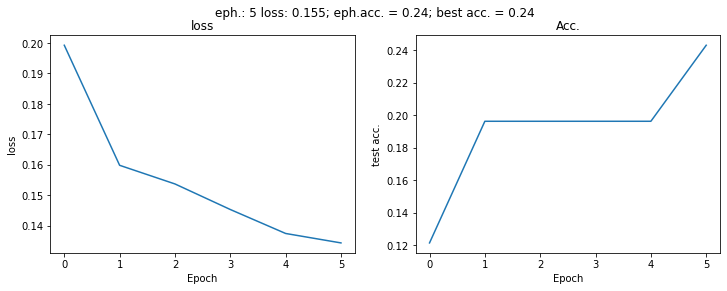

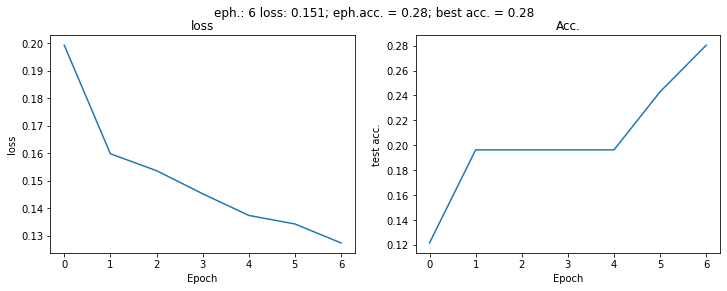

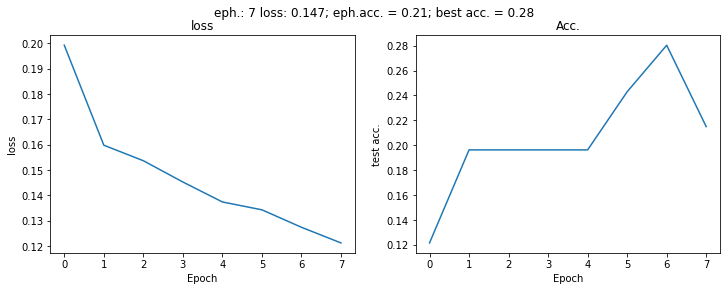

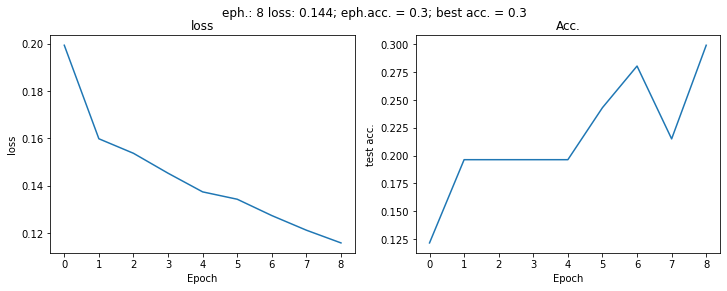

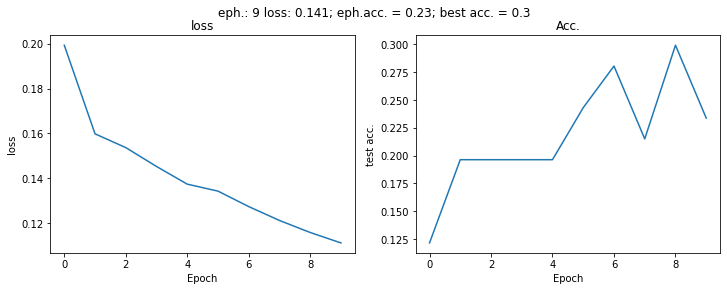

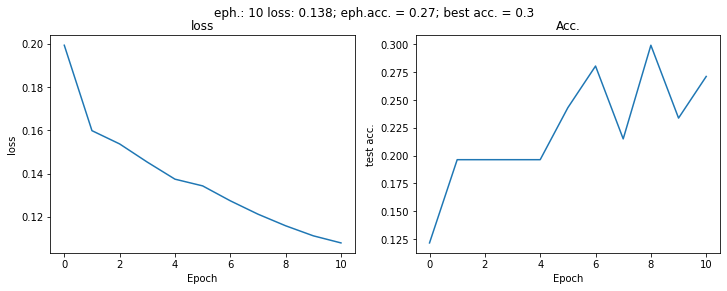

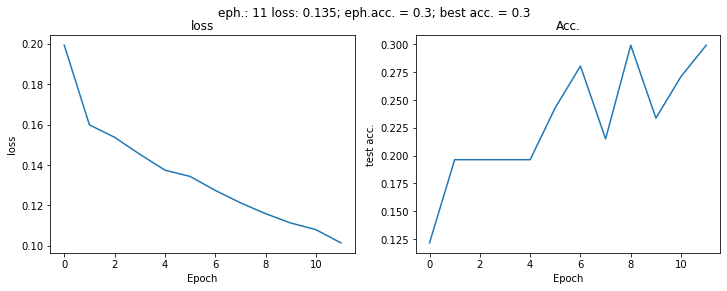

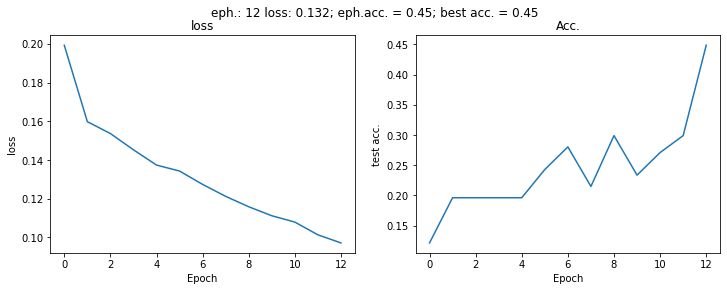

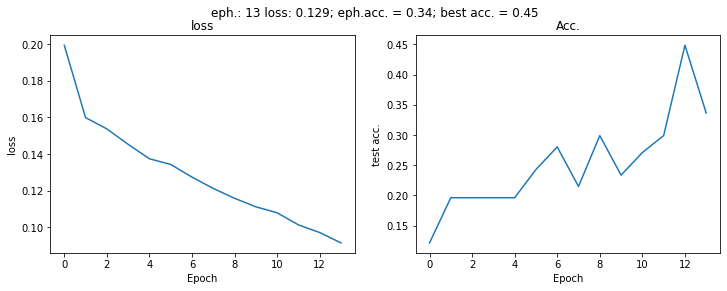

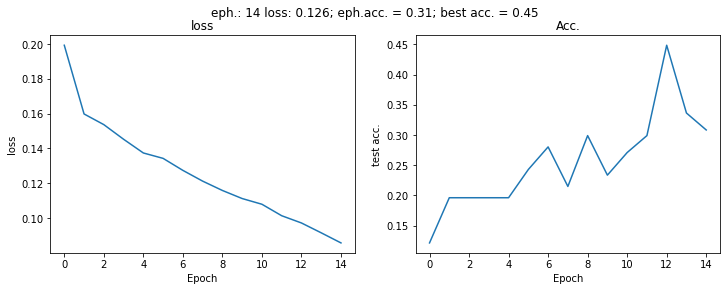

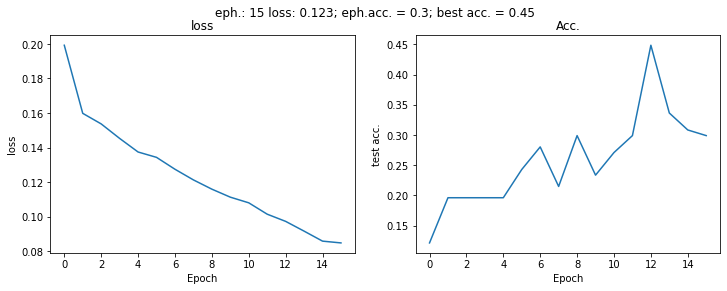

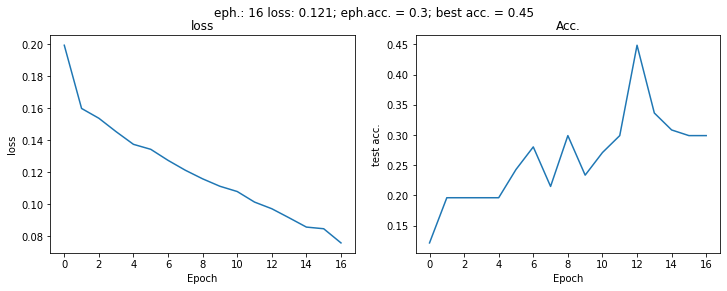

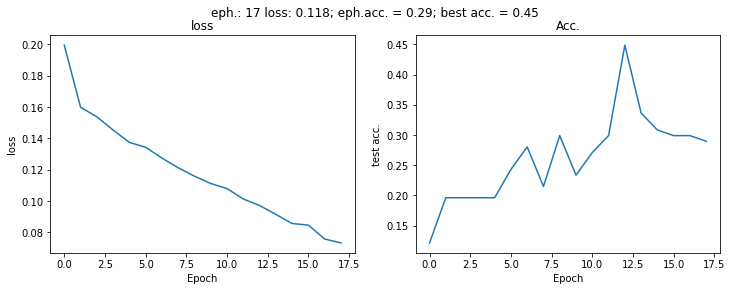

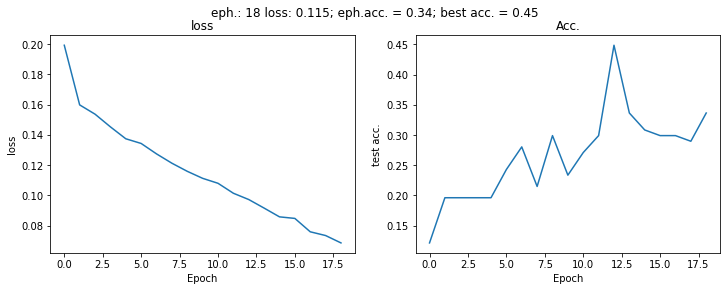

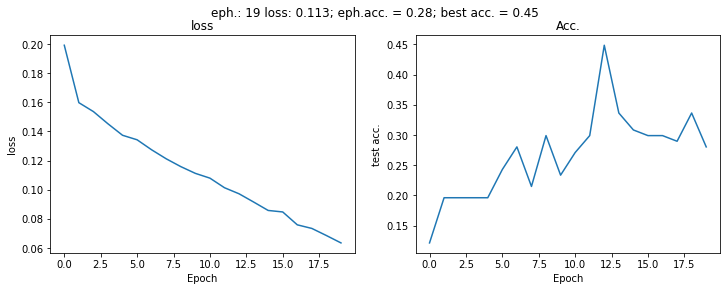

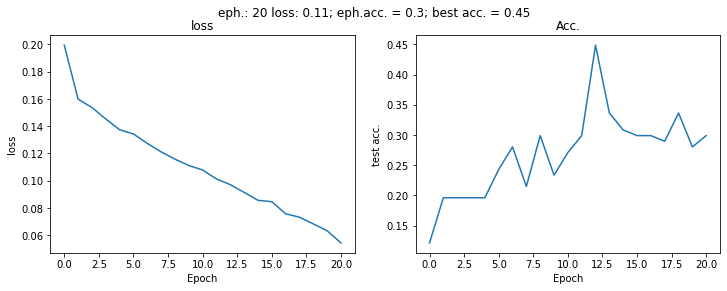

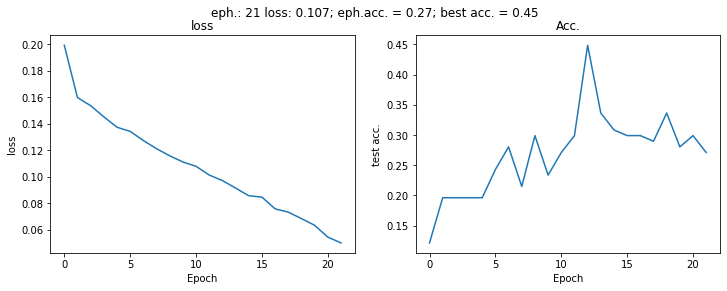

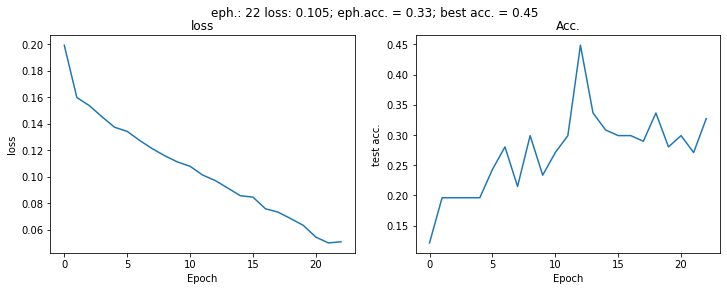

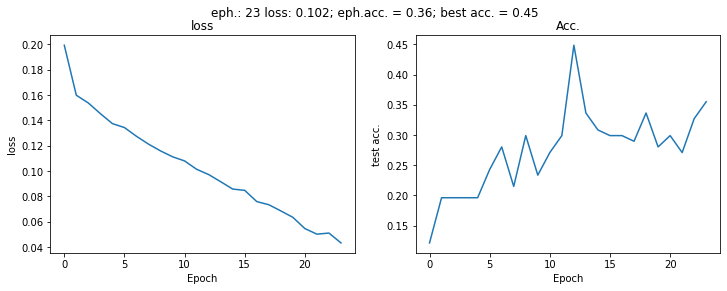

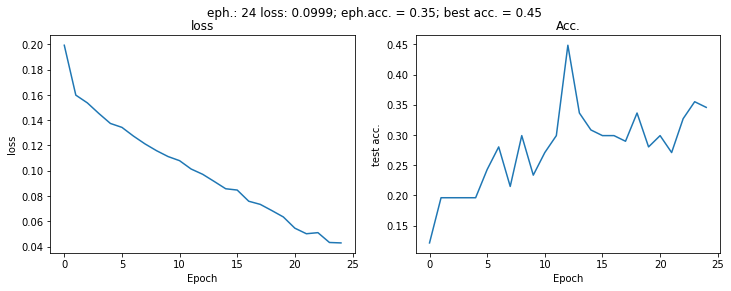

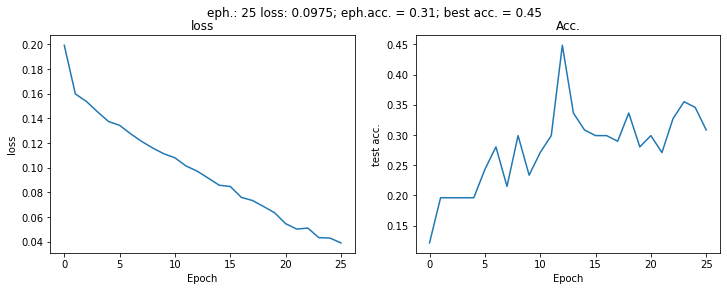

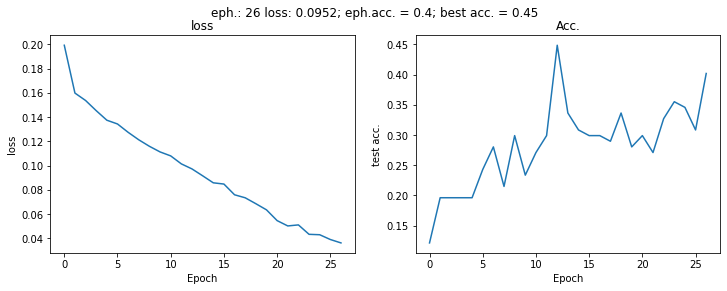

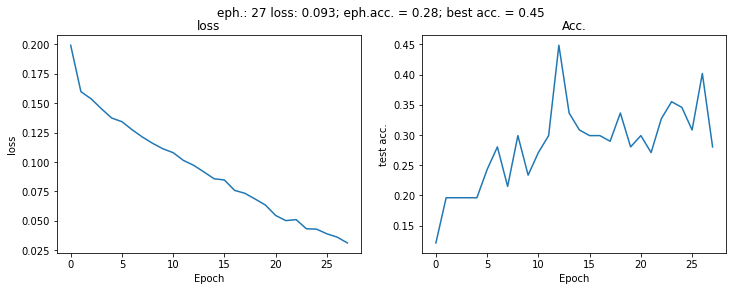

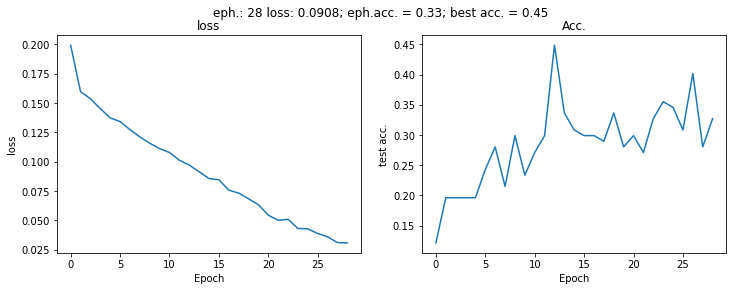

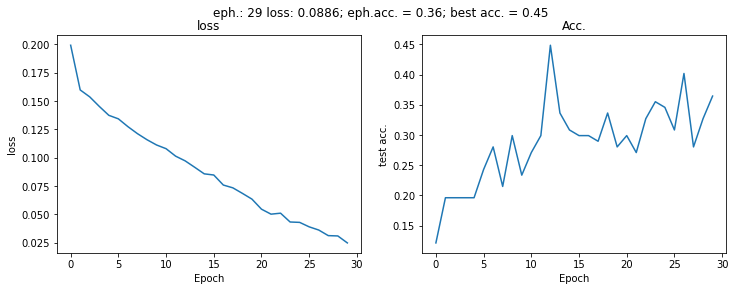

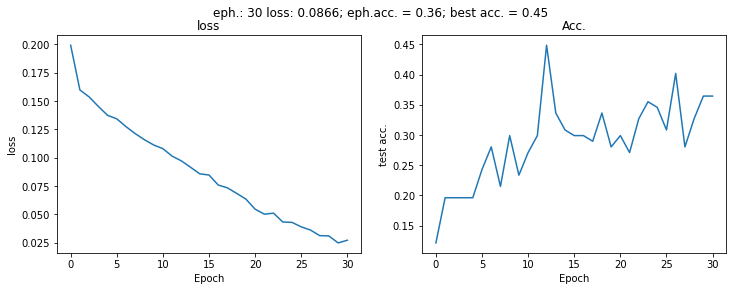

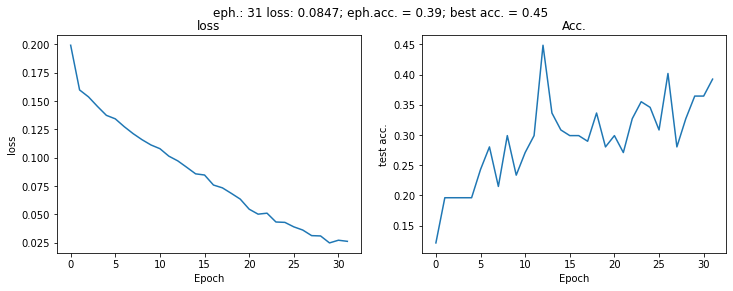

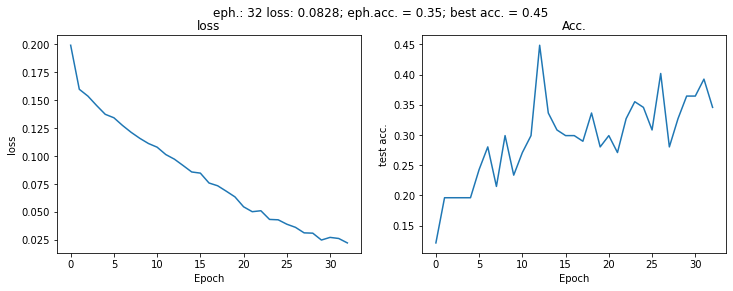

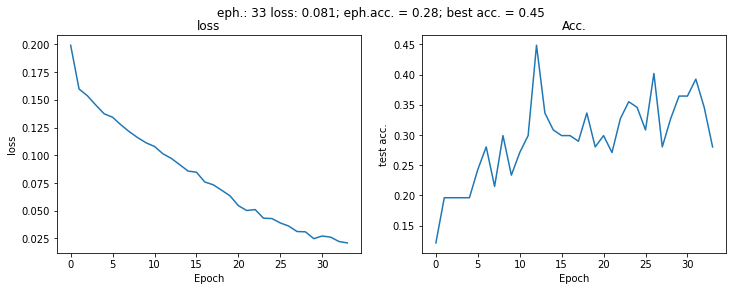

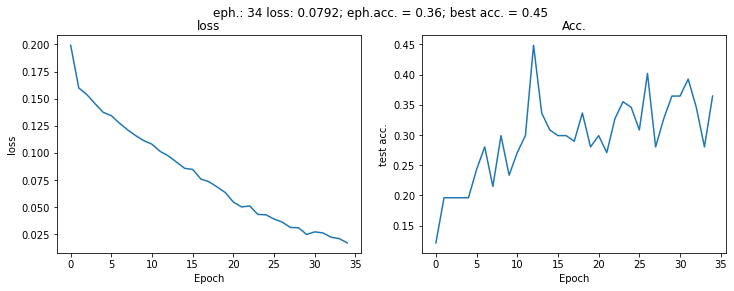

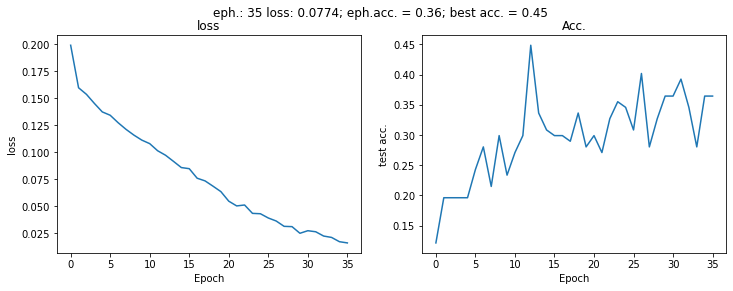

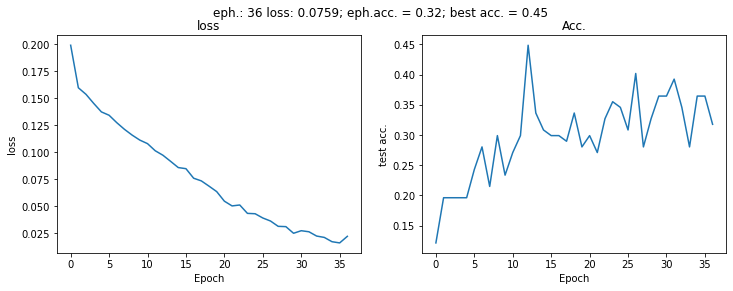

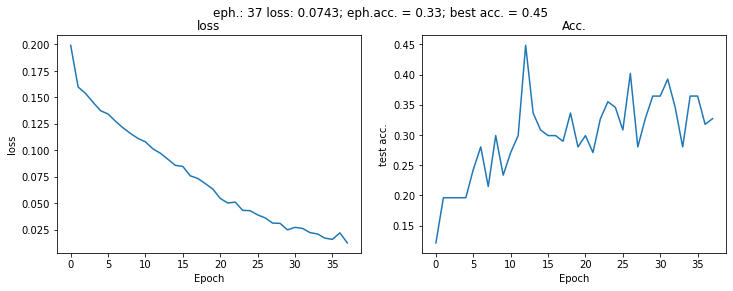

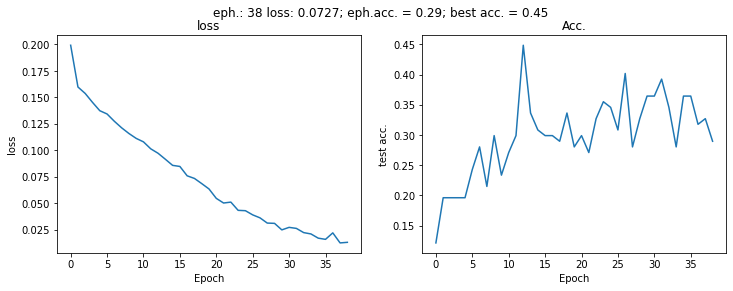

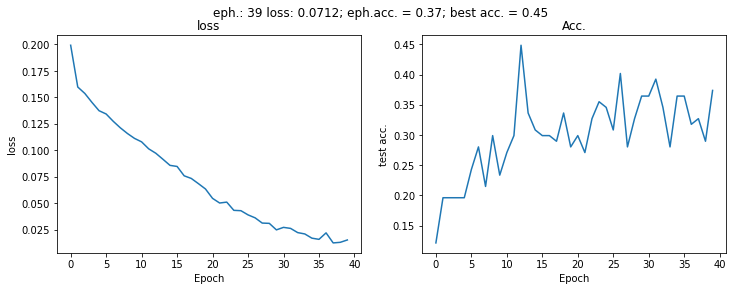

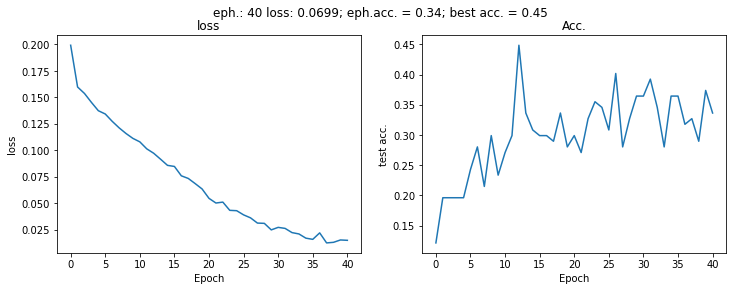

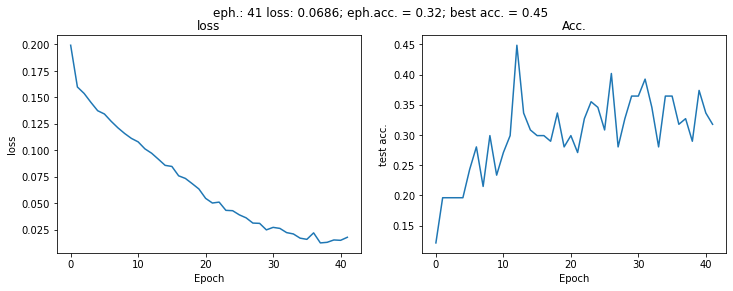

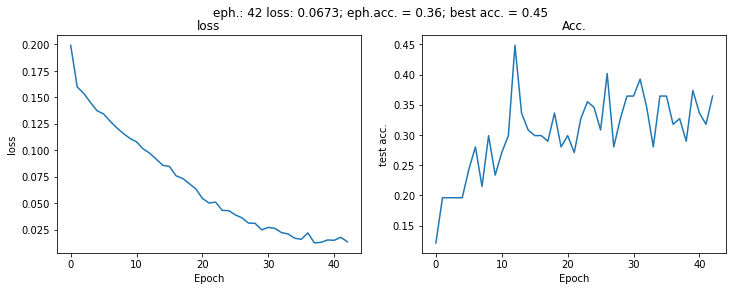

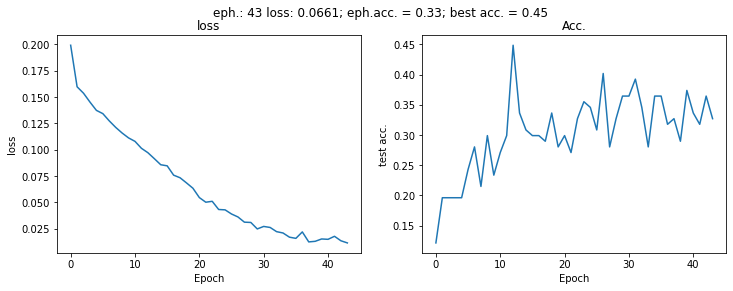

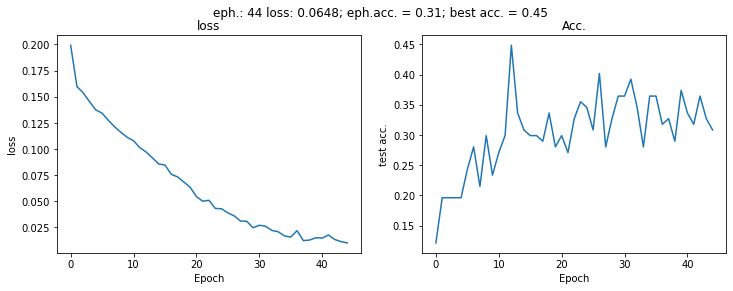

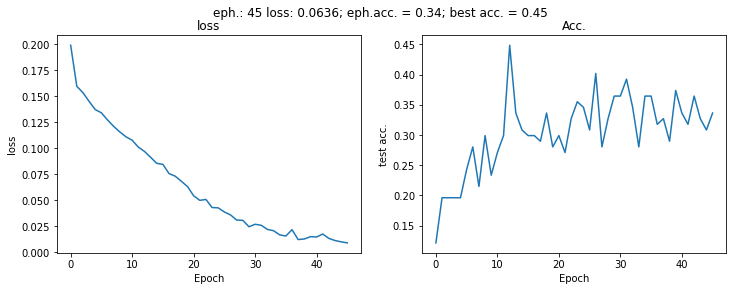

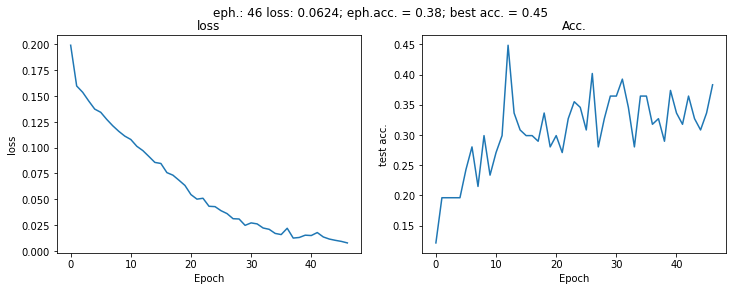

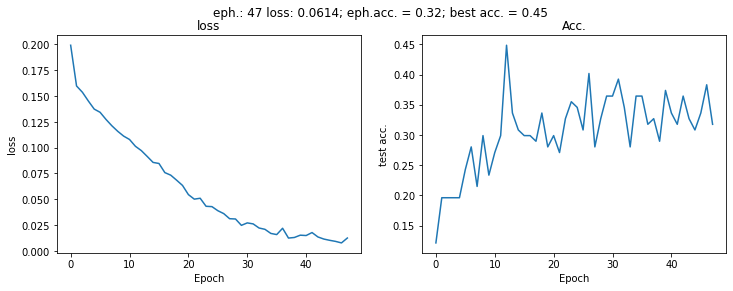

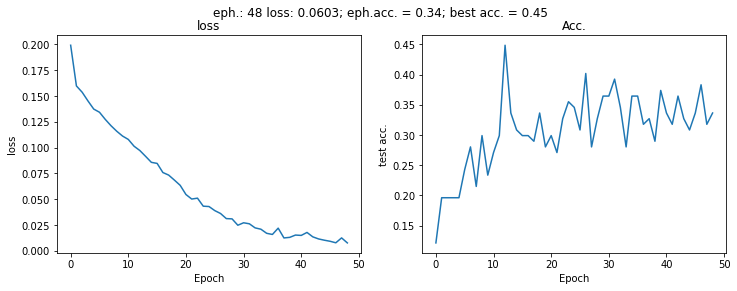

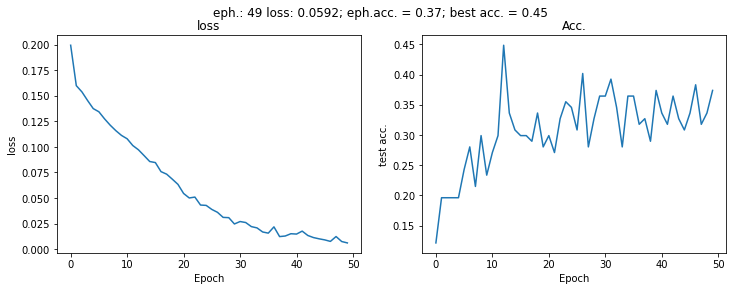

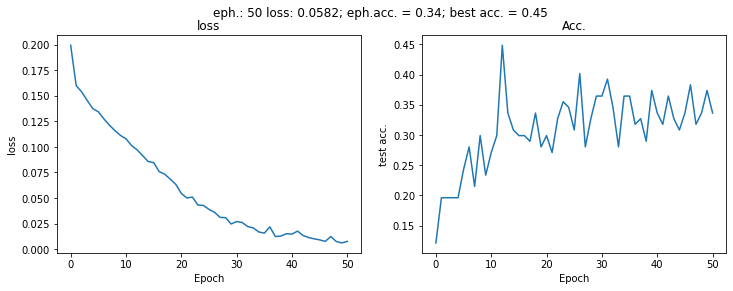

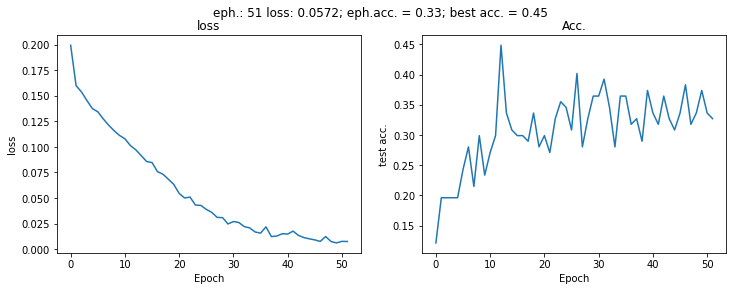

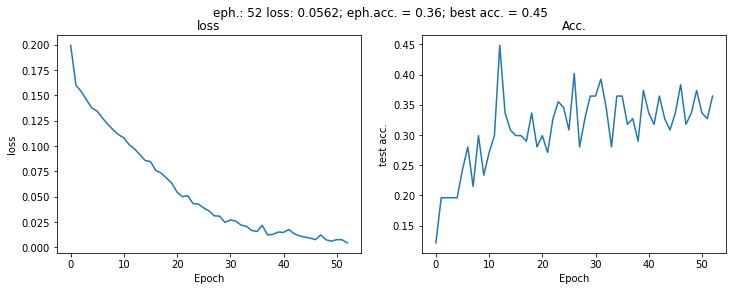

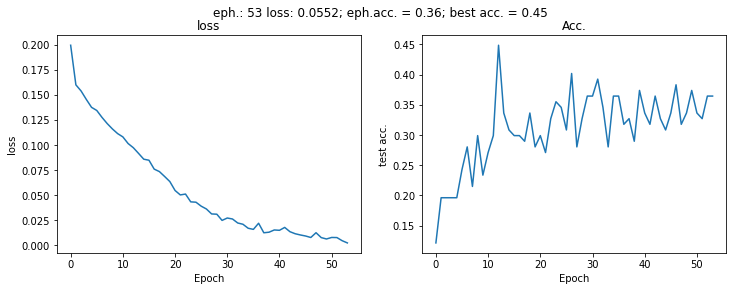

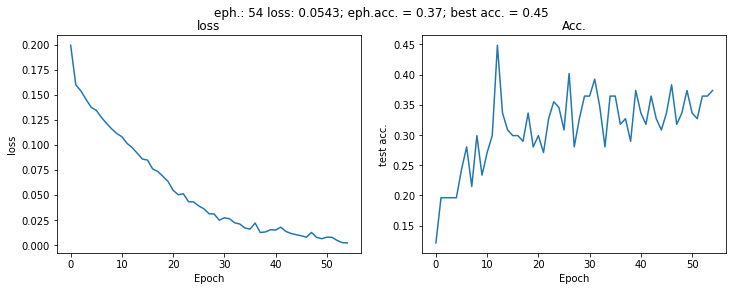

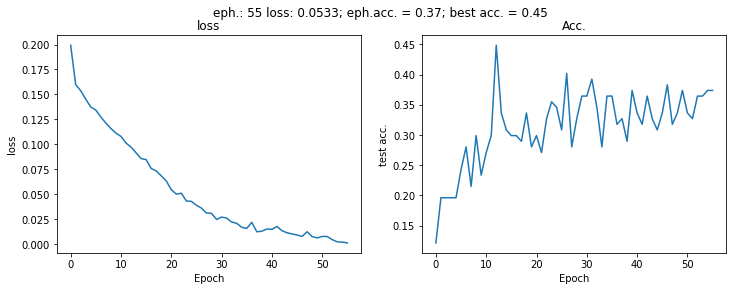

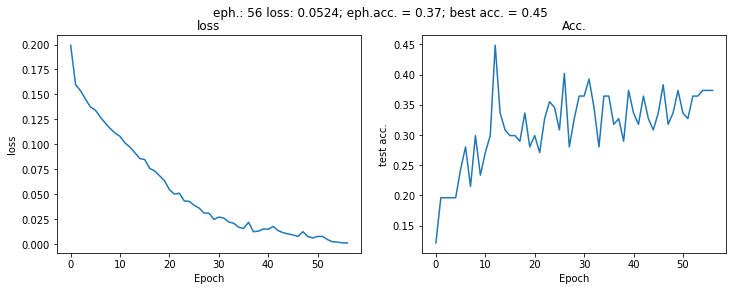

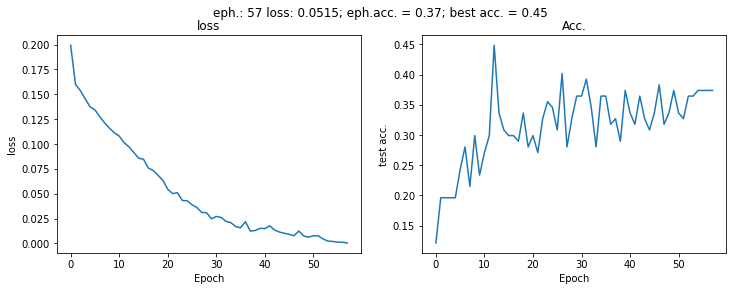

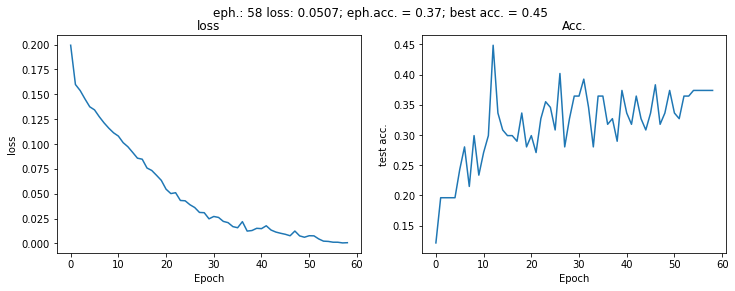

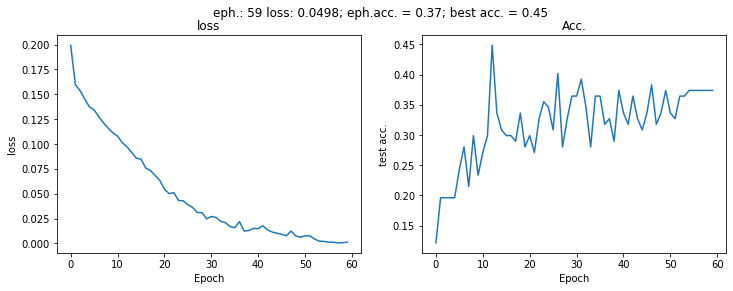

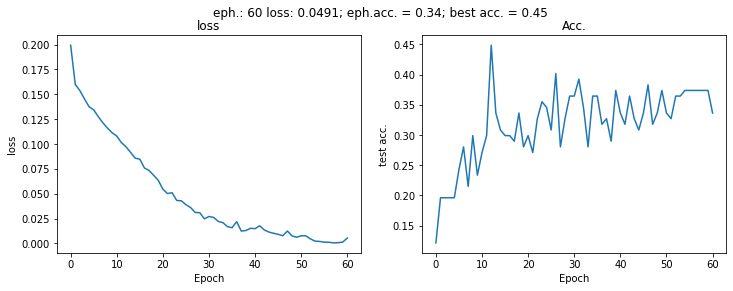

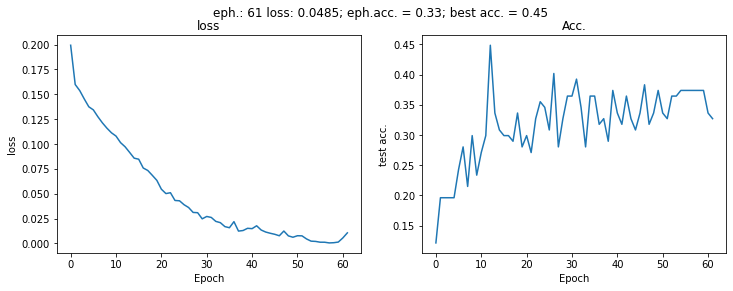

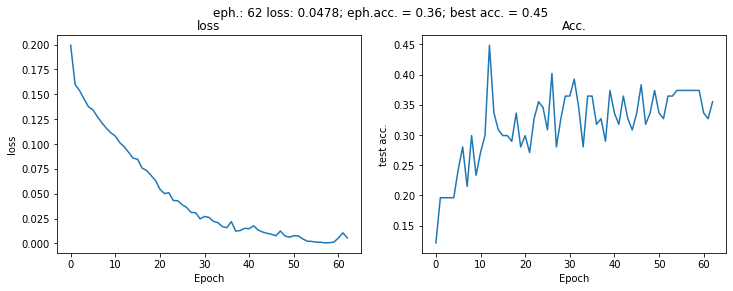

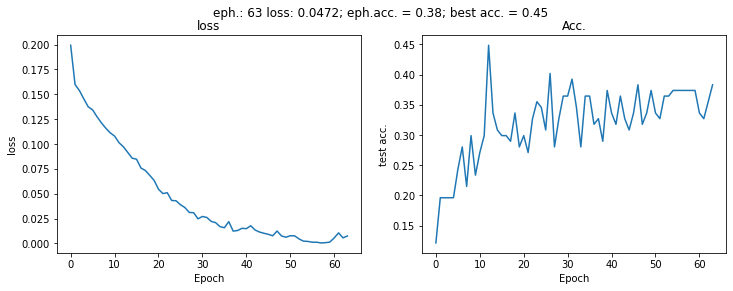

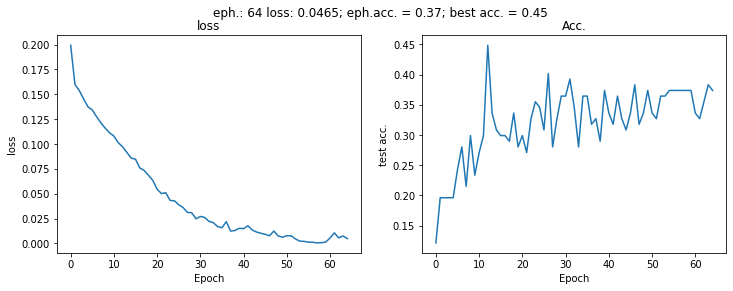

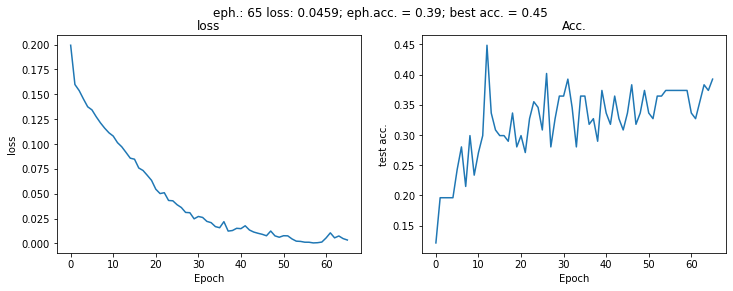

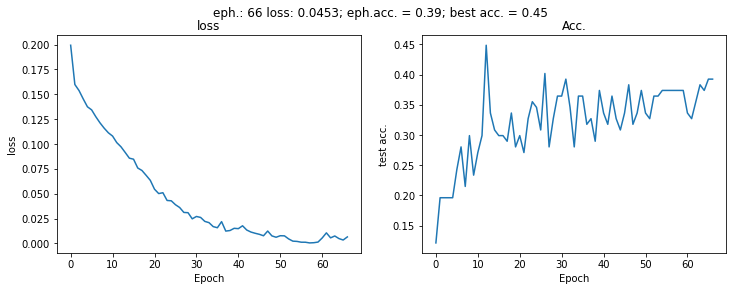

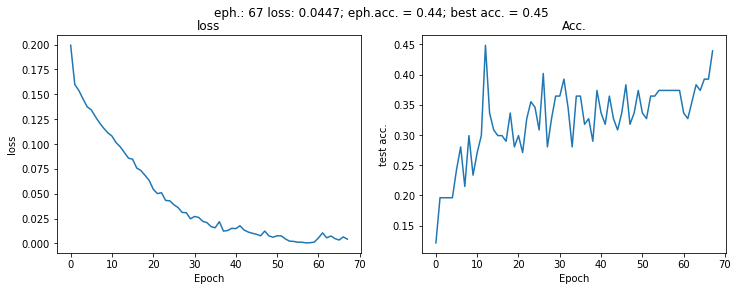

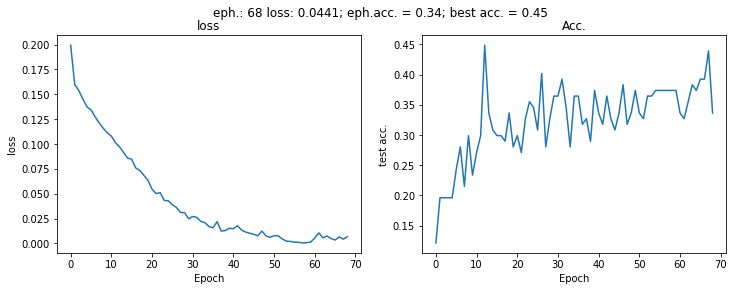

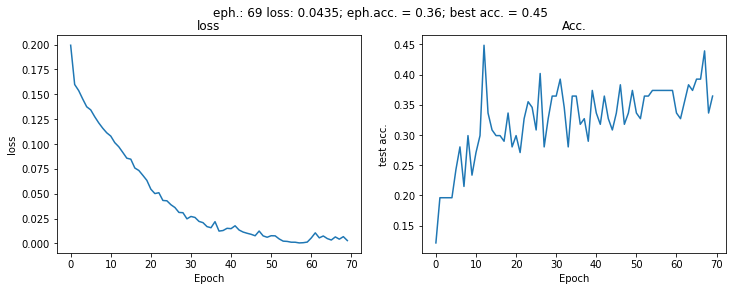

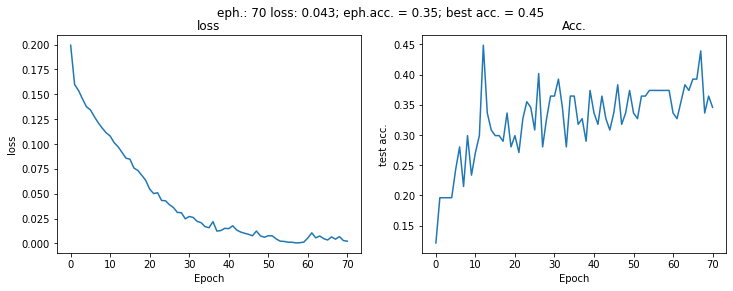

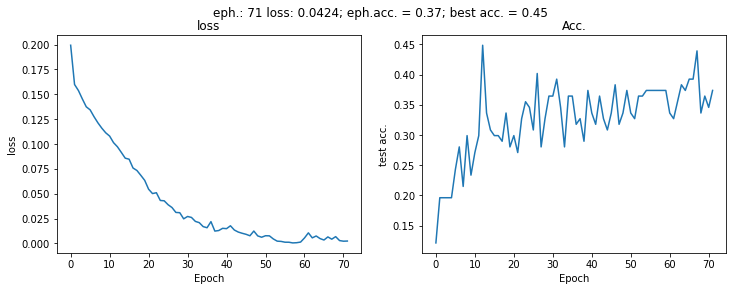

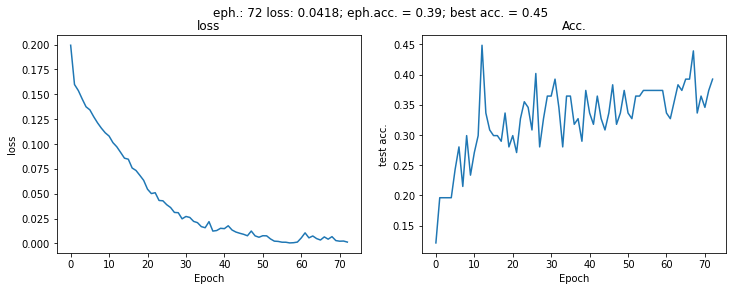

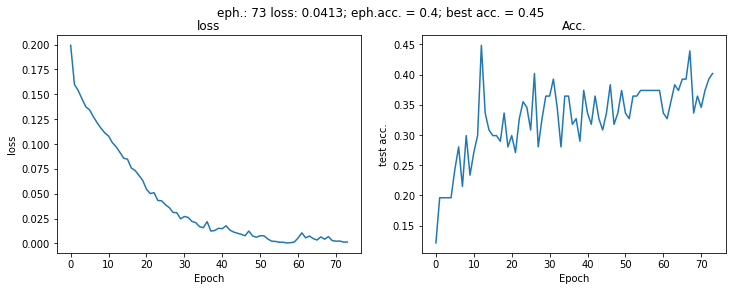

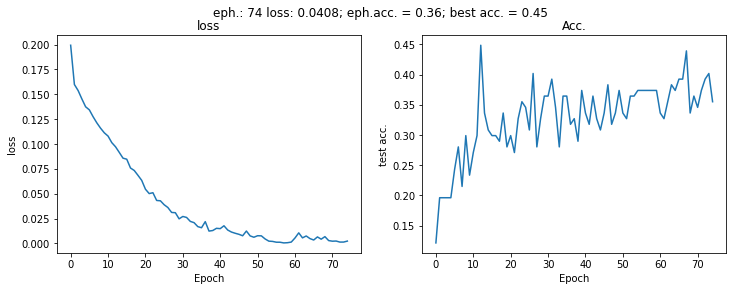

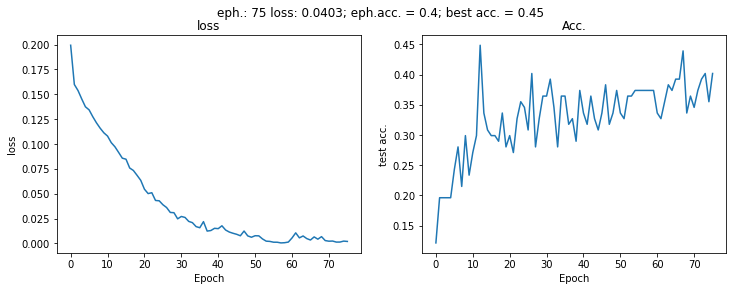

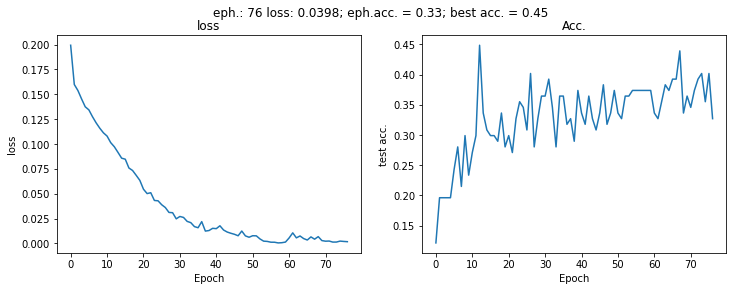

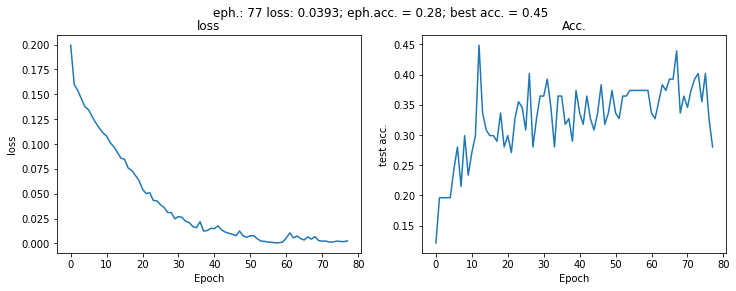

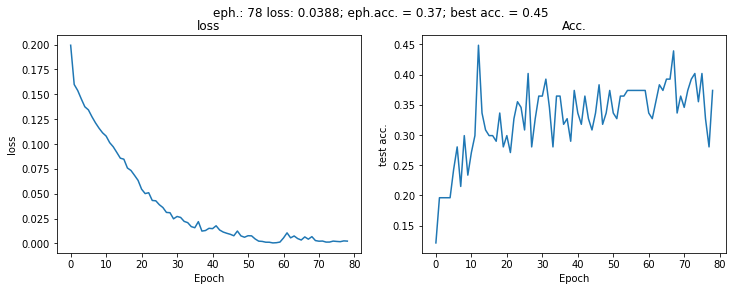

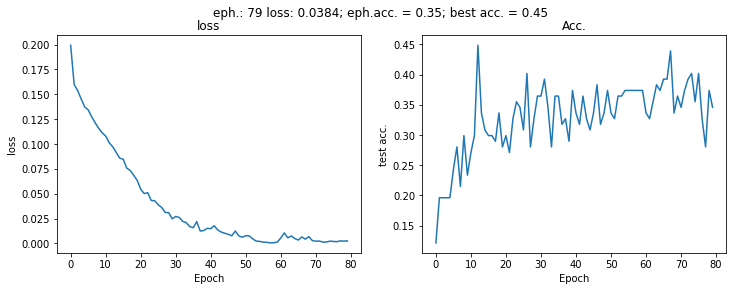

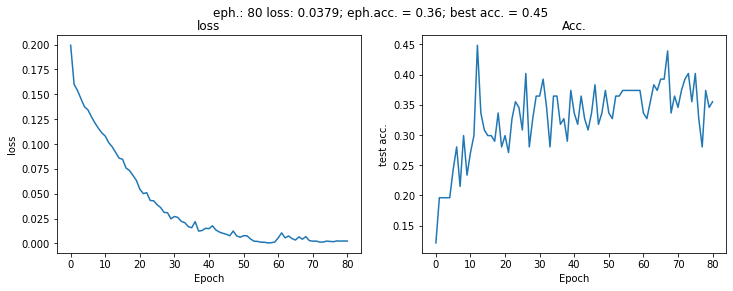

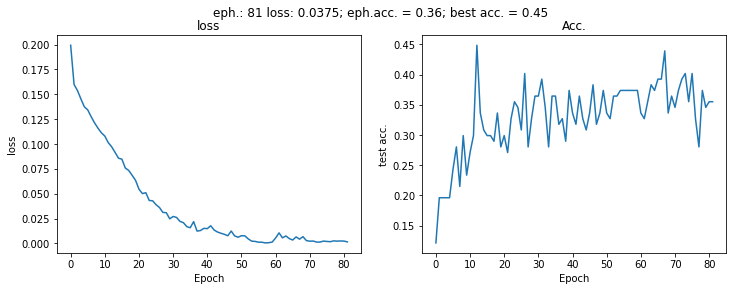

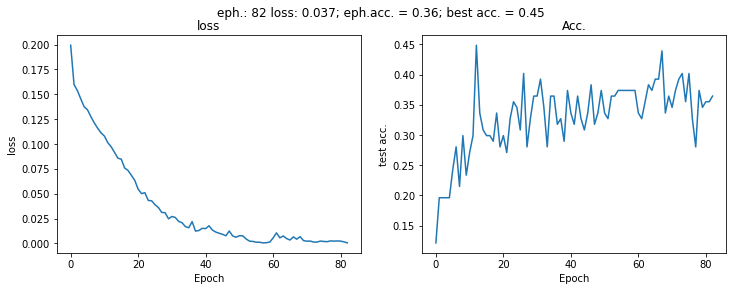

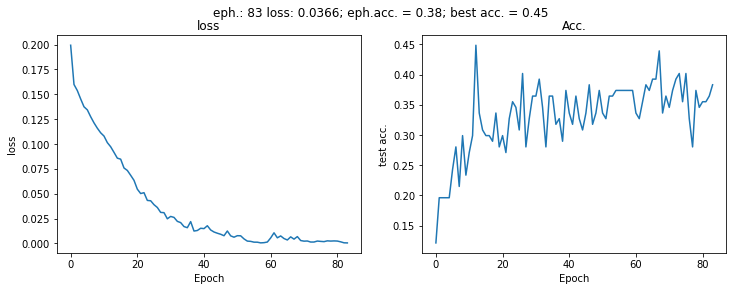

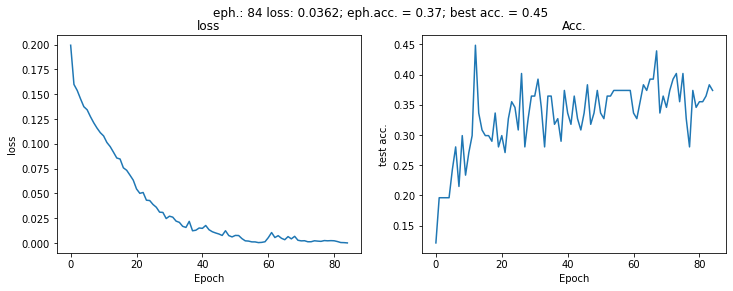

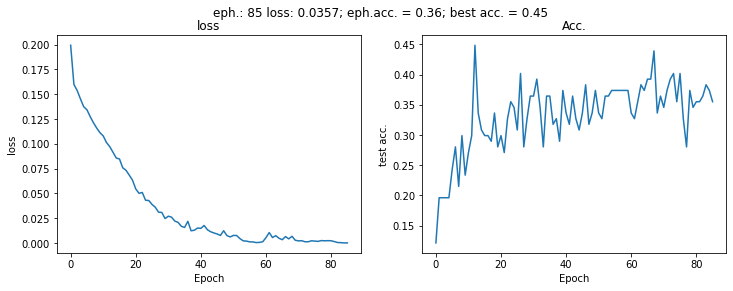

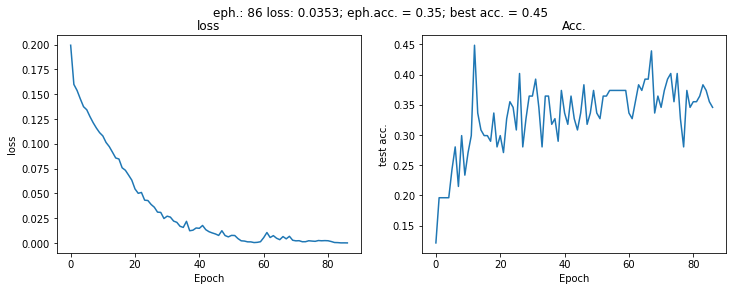

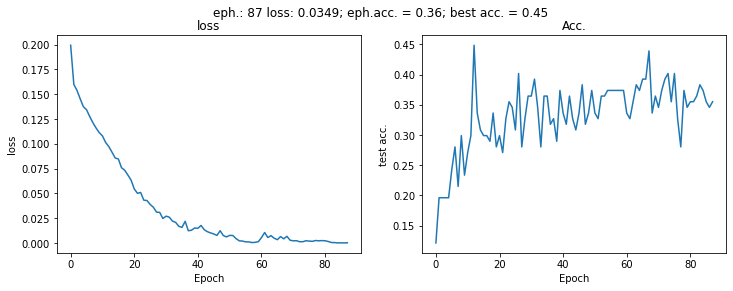

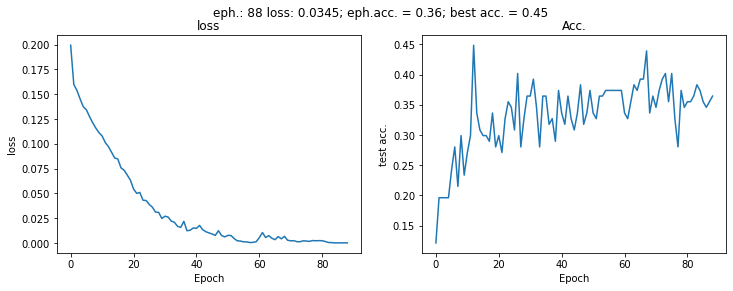

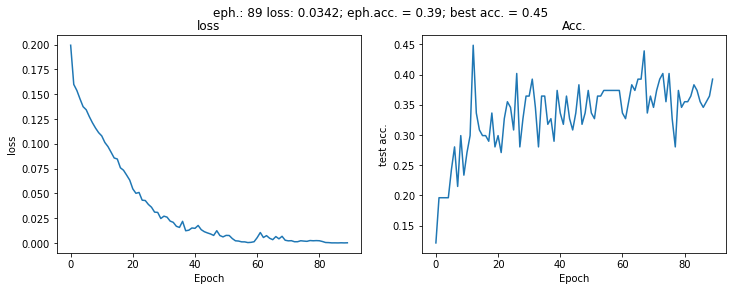

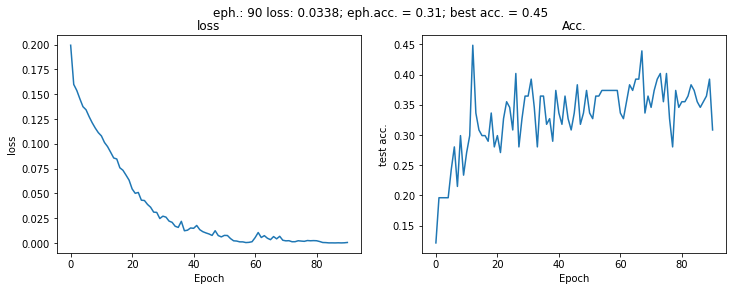

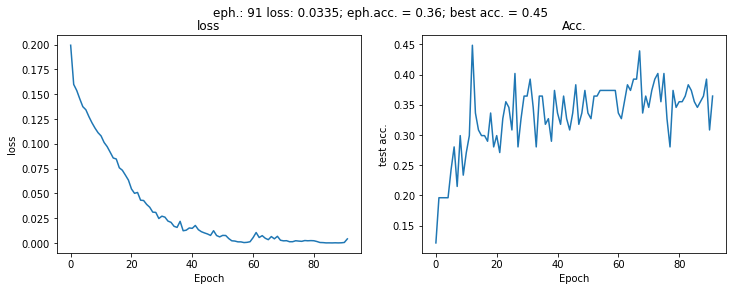

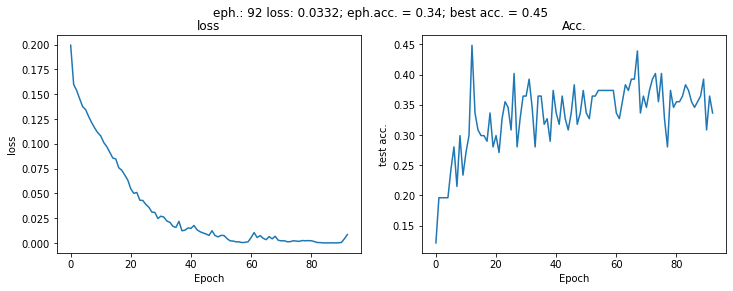

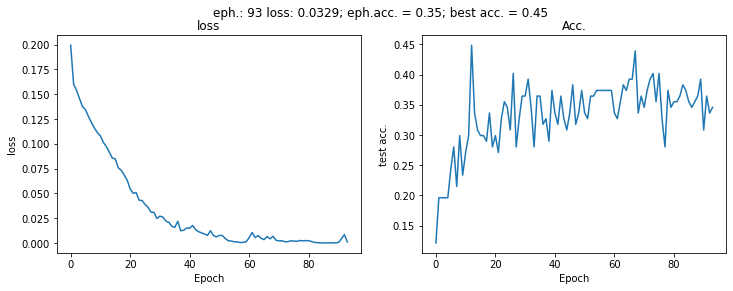

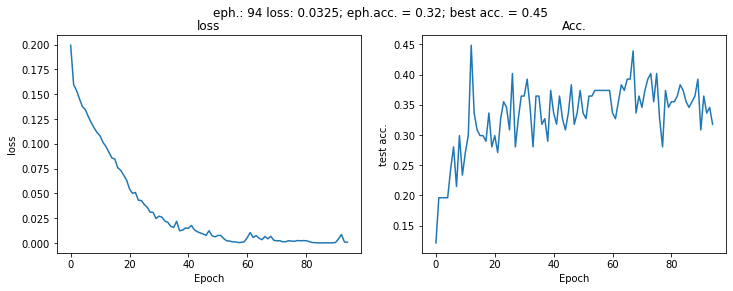

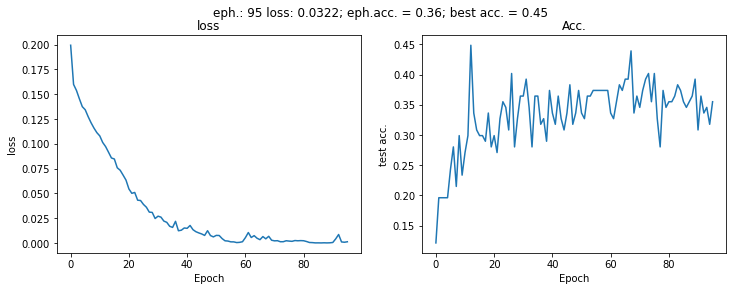

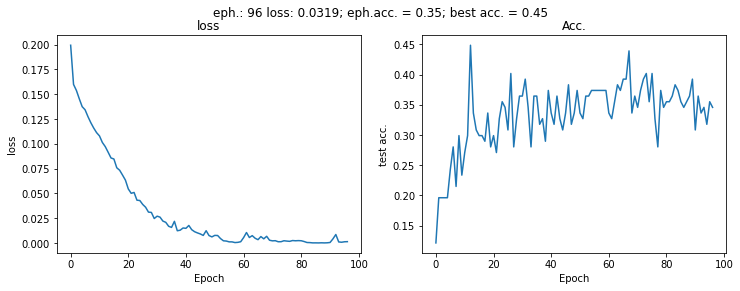

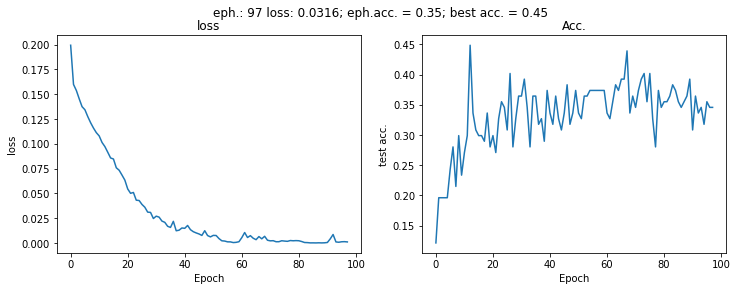

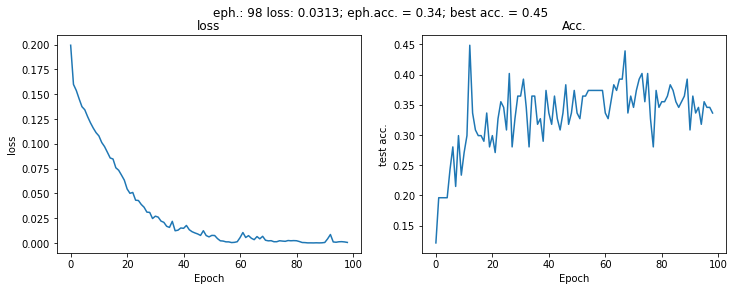

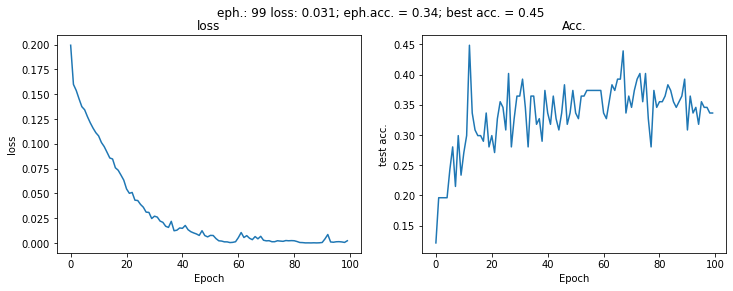

In [114]:
import copy 
from IPython import display

loss_arr = []
test_acc_array = []
max_acc = 0
for iepoch in range(EPOCH_NUM):
  inter_loss_arr = []
  model.train()
  for idata, ilabels in tqdm(train_loader):
    model.zero_grad()
    idata = idata.type(torch.FloatTensor).to(DEVICE)
    ilabels = ilabels.type(torch.FloatTensor).to(DEVICE)
    train_output = model(idata)
    #optimizer.zero_grad()
    loss = criterion(train_output, ilabels)
    loss.backward()
    optimizer.step() 
    inter_loss_arr += [loss.item()]
  loss_arr.append(np.mean(inter_loss_arr))
  model.eval()
  with torch.no_grad():
    acc_array = []
    for i_test_data, i_test_labels in test_loader:
          i_test_data = i_test_data.type(torch.FloatTensor).to(DEVICE)
          i_test_labels = i_test_labels.detach().numpy()
          test_output = model(i_test_data)
          test_output = test_output.cpu().detach().numpy()
          test_label = np.argmax(test_output,axis=1)
          true_label = np.argmax(i_test_labels,axis=1)
          acc_array.extend((test_label==true_label))
    acc_val = (np.sum(acc_array)/len(acc_array))
    if acc_val > max_acc:
      max_acc=acc_val
      sd = model.state_dict()
      best_model.load_state_dict(sd)
    test_acc_array.append(acc_val)
    strOUT='eph.: {:} loss: {:.3}; eph.acc. = {:.2}; best acc. = {:.2}'.format(iepoch,np.mean(loss_arr),acc_val,max_acc)
    print(strOUT)

  plt.figure(figsize=(12,4))
  plt.subplot(1,2,1)
  plt.suptitle(strOUT)
  plt.title('loss')
  plt.xlabel('Epoch')
  plt.ylabel('loss')
  plt.plot(loss_arr)
  plt.subplot(1,2,2)
  plt.title('Acc.')
  plt.xlabel('Epoch')
  plt.ylabel('test acc.')
  plt.plot(test_acc_array)
  display.clear_output(wait=True)
  display.display(plt.gcf())






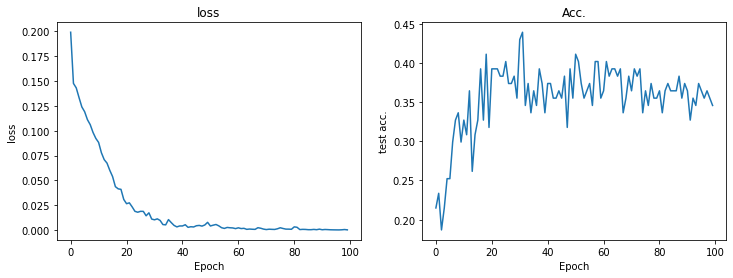

In [83]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title('loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.plot(loss_arr)
plt.subplot(1,2,2)
plt.title('Acc.')
plt.xlabel('Epoch')
plt.ylabel('test acc.')
plt.plot(test_acc_array)

In [89]:
test_output = best_model(i_test_data.cpu())
test_label = np.argmax(test_output.detach().numpy(),axis=1)
true_label = np.argmax(i_test_labels,axis=1)
print(test_label,true_label)

[ 0 19 21] [18  7  3]


In [116]:
PATH = '/content/drive/MyDrive/mldm21_project/'
torch.save(best_model.state_dict(), PATH+'modelRes34LR01')